In [26]:
import numpy as np
import pandas as pd
import dataframe_image as dfi

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

import folium
import json

import warnings
warnings.filterwarnings(action='ignore')

In [27]:
# 데이터프레임을 그림 파일로 저장
option = 2 # 1 : dfi / 2 : df2img
import df2img
def savedf(df, path):
    if option == 1:
        dfi.export(df, path)
    if option == 2:
        df2img.save_dataframe(fig=df2img.plot_dataframe(df), filename=path)

# 속성 선택 (feature selection)

## 데이터 불러오기 및 병합

In [28]:
collected_data = pd.read_csv('../../data/data_c_final/2c201_1230_collected_data.csv')
collected_data.set_index("지역", inplace=True)
collected_data.head()

,위도,경도,쏘카존 수,녹지,주거,공업,상업,인구,대학교 수,아파트 수,지하철역 수,정류장 수,환승역 수,행복주택 수,대학생 수,2030인구
지역,,,,,,,,,,,,,,,,
수원시 장안구,37.303971,127.001743,18,0.272727,0.727273,0.000000,0.000000,271012,4,200,1,409,0,0,34441,82294.55980
수원시 권선구,37.257687,126.963532,16,0.625000,0.312500,0.062500,0.000000,367004,1,159,4,537,0,1,11033,111443.15610
수원시 팔달구,37.282570,127.011718,20,0.136364,0.409091,0.000000,0.454545,192225,0,65,4,185,2,1,0,58370.37385
수원시 영통구,37.259600,127.042341,34,0.142857,0.571429,0.285714,0.000000,360127,21,129,6,380,0,3,22911,109354.91020
용인시 처인구,37.234346,127.192965,29,0.823529,0.058824,0.000000,0.117647,259872,15,112,9,1234,0,1,13084,67270.69540


In [29]:
# collected_data.sort_values(by='지역',inplace=True)
# collected_data['dumb'] = np.arange(len(collected_data))
# collected_data

In [30]:
hackathon_data_original = pd.read_csv("../../data/20211022_수요예측_hackathon_data.csv", encoding='cp949')
hackathon_data_original.head()

,region1,region2,reservation_return_at,reservation_start_at,age_group,gender,car_model
0,울산광역시,남구,2019-09-29 21:25:40+00:00,2019-09-29 19:20:00+00:00,1,male,경형
1,울산광역시,남구,2019-07-13 13:11:21+00:00,2019-07-13 11:00:00+00:00,1,male,준중형
2,울산광역시,남구,2019-09-16 23:43:08+00:00,2019-09-16 19:10:00+00:00,1,male,준중형
3,울산광역시,남구,2019-08-09 06:17:41+00:00,2019-08-09 00:20:00+00:00,1,male,준중형
4,울산광역시,남구,2019-07-24 12:36:29+00:00,2019-07-24 09:00:00+00:00,2,male,경형


In [31]:
hackathon_data = pd.DataFrame(hackathon_data_original['region2'].value_counts())
hackathon_data.reset_index(inplace=True)
hackathon_data['index'].replace({ 
    '수원시\u3000팔달구':'수원시 팔달구', '수원시\u3000영통구':'수원시 영통구', '용인시\u3000기흥구':'용인시 기흥구',
    '고양시\u3000일산동구':'고양시 일산동구', '안양시\u3000동안구':'안양시 동안구', '고양시\u3000일산서구':'고양시 일산서구',
    '성남시\u3000수정구':'성남시 수정구', '수원시\u3000장안구':'수원시 장안구', '성남시\u3000중원구':'성남시 중원구',
    '안산시\u3000단원구':'안산시 단원구', '용인시\u3000수지구':'용인시 수지구', '고양시\u3000덕양구':'고양시 덕양구',
    '용인시\u3000처인구':'용인시 처인구', '안양시\u3000만안구':'안양시 만안구', '성남시\u3000분당구':'성남시 분당구',
    '수원시\u3000권선구':'수원시 권선구', '안산시\u3000상록구':'안산시 상록구',}, inplace=True)
hackathon_data.columns = ['지역', '이용 수']
hackathon_data.set_index('지역', inplace=True)
hackathon_data.head()

,이용 수
지역,
성남시 분당구,46782
화성시,35249
고양시 일산동구,31906
남양주시,26546
고양시 덕양구,26253


In [32]:
intersected_rows = set.intersection(set(collected_data.index), set(hackathon_data.index))
intersected_rows = list(intersected_rows)
print(len(intersected_rows),'개 지역 \n',intersected_rows)

16 개 지역 
 ['안양시 만안구', '고양시 일산서구', '고양시 일산동구', '하남시', '양평군', '김포시', '남양주시', '성남시 분당구', '안양시 동안구', '성남시 수정구', '의정부시', '구리시', '화성시', '고양시 덕양구', '성남시 중원구', '광명시']


In [33]:
collected_data_intersected = collected_data[collected_data.index.isin(intersected_rows)]
collected_data_intersected.sort_index(ascending=True, inplace=True)
hackathon_data_intersected = hackathon_data[hackathon_data.index.isin(intersected_rows)]
hackathon_data_intersected.sort_index(ascending=True, inplace=True)
intersected = pd.concat([collected_data_intersected, hackathon_data_intersected],axis=1)
intersected['쏘카존 수 대비 이용 수'] = intersected['이용 수']/intersected['쏘카존 수']
intersected

,위도,경도,쏘카존 수,녹지,주거,공업,상업,인구,대학교 수,아파트 수,지하철역 수,정류장 수,환승역 수,행복주택 수,대학생 수,2030인구,이용 수,쏘카존 수 대비 이용 수
지역,,,,,,,,,,,,,,,,,,
고양시 덕양구,37.637431,126.823745,48,0.656250,0.343750,0.000000,0.000000,487874,6,274,9,1205,2,8,4210,131281.05900,26253,546.937500
고양시 일산동구,37.658622,126.771006,51,0.461538,0.461538,0.000000,0.076923,296590,1,133,6,454,0,0,13923,79808.82212,31906,625.607843
고양시 일산서구,37.677991,126.741105,29,0.500000,0.375000,0.000000,0.125000,290738,0,140,4,635,0,0,0,78234.11890,16052,553.517241
광명시,37.478618,126.856271,28,0.222222,0.666667,0.000000,0.111111,288182,0,89,3,445,0,0,0,76757.00000,22645,808.750000
구리시,37.594266,127.121253,19,0.500000,0.500000,0.000000,0.000000,188876,0,111,2,313,0,1,0,51033.00000,13011,684.789474
김포시,37.615350,126.707165,55,0.400000,0.533333,0.066667,0.000000,484194,3,229,9,1325,0,7,232,127499.00000,21500,390.909091
남양주시,37.635985,127.212283,57,0.526316,0.473684,0.000000,0.000000,737366,2,385,13,1803,0,6,8100,176762.00000,26546,465.719298
성남시 분당구,37.382819,127.110546,58,0.500000,0.500000,0.000000,0.000000,482026,1,231,12,694,3,0,0,137576.86410,46782,806.586207
성남시 수정구,37.450396,127.137254,18,0.631579,0.368421,0.000000,0.000000,232125,11,91,9,436,2,5,20021,66251.67434,18773,1042.944444


## 상관분석 (pearson correlation analysis)

In [34]:
pearson = intersected.corr()[['이용 수', '쏘카존 수 대비 이용 수']]
pearson['abs value'] = abs(pearson['이용 수'])
pearson.sort_values(by='abs value', ascending=False, inplace=True)
pearson.drop(columns = ['abs value'], inplace=True)
pearson.drop(index = ['이용 수', '쏘카존 수 대비 이용 수'], inplace=True)
pearson

,이용 수,쏘카존 수 대비 이용 수
쏘카존 수,0.806230,-0.537069
2030인구,0.686101,-0.334138
인구,0.649762,-0.390717
환승역 수,0.637355,0.078405
아파트 수,0.623385,-0.388349
경도,-0.393671,0.128923
주거,0.381949,0.060353
녹지,-0.369392,-0.148646
정류장 수,0.335510,-0.491441
지하철역 수,0.286200,-0.312177


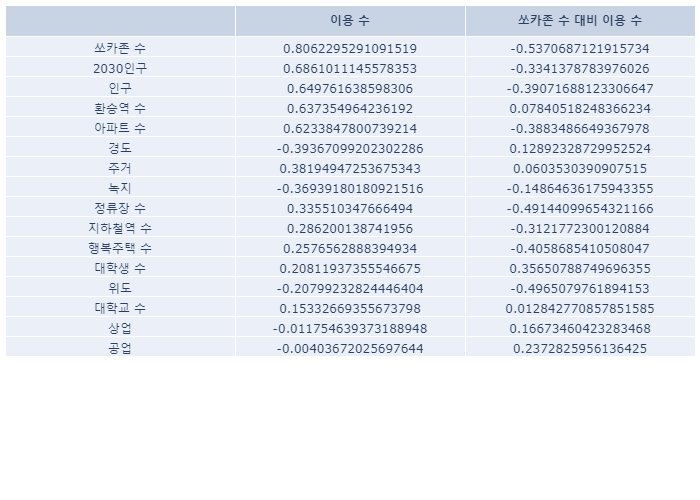

In [35]:
savedf(pearson, "results/1b_201_0112_pearson.png")

In [36]:
pearson[pearson.abs() > 0.15]

,이용 수,쏘카존 수 대비 이용 수
쏘카존 수,0.806230,-0.537069
2030인구,0.686101,-0.334138
인구,0.649762,-0.390717
환승역 수,0.637355,NaN
아파트 수,0.623385,-0.388349
경도,-0.393671,NaN
주거,0.381949,NaN
녹지,-0.369392,NaN
정류장 수,0.335510,-0.491441
지하철역 수,0.286200,-0.312177


In [37]:
# sns.pairplot(intersected)

## 회귀분석 (linear regression analysis)

In [38]:
# 다중공선성(multicollinearity) 분석
intersected.corr()>0.7

,위도,경도,쏘카존 수,녹지,주거,공업,상업,인구,대학교 수,아파트 수,지하철역 수,정류장 수,환승역 수,행복주택 수,대학생 수,2030인구,이용 수,쏘카존 수 대비 이용 수
위도,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
경도,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
쏘카존 수,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,True,True,False
녹지,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
주거,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
공업,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
상업,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
인구,False,False,True,False,False,False,False,True,False,True,False,True,False,True,False,True,False,False
대학교 수,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
아파트 수,False,False,True,False,False,False,False,True,False,True,False,True,False,True,False,True,False,False


### sklearn

In [39]:
intersected.columns

Index(['위도', '경도', '쏘카존 수', '녹지', '주거', '공업', '상업', '인구', '대학교 수', '아파트 수',
       '지하철역 수', '정류장 수', '환승역 수', '행복주택 수', '대학생 수', '2030인구', '이용 수',
       '쏘카존 수 대비 이용 수'],
      dtype='object')

In [40]:
independents = intersected.copy()
independents = independents.drop(["이용 수", "쏘카존 수 대비 이용 수"], axis=1)
dependent = intersected["이용 수"]
independents.shape, dependent.shape

((16, 16), (16,))

In [41]:
# R squared의 값은 1에 가깝게 나온다. 독립변수들(feature들)을 하나나 두 개라도 줄이면 R squared의 값은 0.99xxx로 나타난다.
reg = LinearRegression().fit(independents, dependent)
print("R squared :",reg.score(independents, dependent))

R squared : 1.0


In [42]:
pd.DataFrame({'features':independents.columns, "coefficients":reg.coef_})

,features,coefficients
0,위도,-58292.804648
1,경도,16355.045849
2,쏘카존 수,826.879031
3,녹지,-34221.769805
4,주거,-10542.810325
5,공업,-50648.668937
6,상업,95413.249067
7,인구,-0.169465
8,대학교 수,-232.376012
9,아파트 수,190.707798


In [43]:
# 이해할 수 없는 결과가 나왔다. 위도, 경도, 녹지, 주거, 공업, 상업의 coefficient가 굉장히 크게 나왔다.
# 이것은 직관과도 일치하지 않을 뿐더러 상관관계의 결과와도 일치하지 않는다.
# sklearn의 공식문서를 보면 스케일링을 맞춰주는 것이 필요할 수도 있다고 했다.

In [44]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
independents_scaled = scaler.fit_transform(independents.to_numpy())
independents_scaled = pd.DataFrame(independents_scaled, columns=independents.columns, index=independents.index)
independents_scaled.head()

,위도,경도,쏘카존 수,녹지,주거,공업,상업,인구,대학교 수,아파트 수,지하철역 수,정류장 수,환승역 수,행복주택 수,대학생 수,2030인구
지역,,,,,,,,,,,,,,,,
고양시 덕양구,0.813094,0.151001,0.811321,0.558036,0.458333,0.0,0.000000,0.465198,0.222222,0.673352,0.40,0.363844,0.666667,0.470588,0.210279,0.460164
고양시 일산동구,0.852445,0.082691,0.867925,0.307692,0.615385,0.0,0.615385,0.221678,0.037037,0.269341,0.25,0.077422,0.000000,0.000000,0.695420,0.244822
고양시 일산서구,0.888413,0.043961,0.452830,0.357143,0.500000,0.0,1.000000,0.214228,0.000000,0.289398,0.15,0.146453,0.000000,0.000000,0.000000,0.238234
광명시,0.518186,0.193130,0.433962,0.000000,0.888889,0.0,0.888889,0.210974,0.000000,0.143266,0.10,0.073989,0.000000,0.000000,0.000000,0.232054
구리시,0.732939,0.536347,0.264151,0.357143,0.666667,0.0,0.000000,0.084549,0.000000,0.206304,0.05,0.023646,0.000000,0.058824,0.000000,0.124434


In [45]:
reg = LinearRegression().fit(independents_scaled, dependent)
print("R squared :",reg.score(independents_scaled, dependent))

R squared : 1.0


In [46]:
result = pd.DataFrame({'features':independents.columns, "coefficients":reg.coef_})
result

,features,coefficients
0,위도,-31391.724573
1,경도,12626.960576
2,쏘카존 수,43824.588622
3,녹지,-9852.056115
4,주거,8259.022639
5,공업,-3232.647603
6,상업,14621.011197
7,인구,-133113.553726
8,대학교 수,-6274.152319
9,아파트 수,66557.021504


In [47]:
result['abs coef.'] = abs(result['coefficients'])
result.sort_values(by='abs coef.', ascending=False, inplace=True)
result.drop(columns = ['abs coef.'], inplace=True)
result

,features,coefficients
7,인구,-133113.553726
9,아파트 수,66557.021504
2,쏘카존 수,43824.588622
0,위도,-31391.724573
11,정류장 수,25174.597670
6,상업,14621.011197
15,2030인구,13166.869651
1,경도,12626.960576
3,녹지,-9852.056115
12,환승역 수,8261.080976


In [48]:
# 아까보다는 나아졌지만, 여전히 이상한 결과이기는 하다.
# 위의 결과를 통해서 보면 '이용 수'에 많은 영향을 미치는 요인은 '인구', '아파트 수', '쏘캬존 수'. '위도', '정류장 수', '상업' 순이다.
# 이 순서 자체는 이상할 게 없을 수 있으나, '인구'의 계수는 음수이다. 다시 말해, 인구가 적을 수록 이용수가 많다는 말이므로, 이 결과는 이상하다.

In [49]:
import statsmodels.api as sm
#define response variable
y = dependent
#define predictor variables
x = independents
#add constant to predictor variables
x = sm.add_constant(x)
#fit linear regression model
model = sm.OLS(y, x).fit()
#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   이용 수   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 30 Jan 2023   Prob (F-statistic):                nan
Time:                        15:51:00   Log-Likelihood:                 172.15
No. Observations:                  16   AIC:                            -312.3
Df Residuals:                       0   BIC:                            -299.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.095e+05        inf          0        n

In [50]:
result = pd.DataFrame(model.params, columns=['coefficients'])
result['abs coef.'] = abs(result['coefficients'])
result.sort_values(by='abs coef.', ascending=False, inplace=True)
result.drop(columns = ['abs coef.'], inplace=True)
result

,coefficients
상업,122793.570870
const,109521.287233
위도,-58292.804573
공업,-23268.346844
주거,16837.511683
경도,16355.045817
녹지,-6841.447763
환승역 수,2753.693653
쏘카존 수,826.879030
대학교 수,-232.376012


In [51]:
# 여전히 이상한 결과가 나왔다. min-max scaling을 하지 않은 결과일까?
# min-max scaling을 적용해서 다시 해보았다.

### `statsmodels`

In [52]:
import statsmodels.api as sm
#define response variable
y = dependent
#define predictor variables
x = independents_scaled
#add constant to predictor variables
x = sm.add_constant(x)
#fit linear regression model
model = sm.OLS(y, x).fit()
#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   이용 수   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 30 Jan 2023   Prob (F-statistic):                nan
Time:                        15:51:00   Log-Likelihood:                 366.26
No. Observations:                  16   AIC:                            -700.5
Df Residuals:                       0   BIC:                            -688.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7145.1859        inf          0        n

In [53]:
result = pd.DataFrame(model.params, columns=['coefficients'])
result['abs coef.'] = abs(result['coefficients'])
result.sort_values(by='abs coef.', ascending=False, inplace=True)
result.drop(columns = ['abs coef.'], inplace=True)
result

,coefficients
인구,-133113.553726
아파트 수,66557.021504
쏘카존 수,43824.588622
위도,-31391.724573
정류장 수,25174.597670
상업,15202.126846
2030인구,13166.869651
경도,12626.960576
주거,11745.716536
환승역 수,8261.080976


In [54]:
# 아까보다 나은 결과인 것으로 보인다.
# 그리고 이것은 sklearn으로 얻은 결과와도 일치한다.

### 다중공산성(multicolinearity) 이슈

In [60]:
# https://datascienceschool.net/03%20machine%20learning/06.04%20%EB%8B%A4%EC%A4%91%EA%B3%B5%EC%84%A0%EC%84%B1%EA%B3%BC%20%EB%B3%80%EC%88%98%20%EC%84%A0%ED%83%9D.html
# 독립변수들은 서로 상관관계가 적어야 한다. 만약 독립변수들 간의 상관관계가 존재한다면, 제대로된 linear regression이 수행되지 않는다.
# 이걸 어떻게 이해해야 할까, 그러니까, 만약 A, B, C가 독립변수이고, C=A+2B라는 관계가 성립한다면,
# 종속변수 y를 A, B, C의 linear combination으로 표현할 때의 coefficient들을 결정하기가 어려워진다.
# 예를 들어, y = 5A+2B+C라는 식이 optimal하다면, y = 6A+4B라는 식도 마찬가지로 optimal하다. (두 case의 MSE가 같다.)
# 그러니까 coefficient tuple을 (5,2,1)로 할지, (6,4,0)으로 할지 애매해진다. (사실, optimal한 coefficient tuple은 무한히 많다.)
# 방금은 C=A+2B와 같이 linear relationship을 상정했지만, nonlinear relationship일 수도 있다.
# 하지만 nonlinear relationship이라고 하더라도, 여전히 coefficient를 정하기 어려울 수도 있다.
# 여하튼, 이러한 다중공산성 이슈를 해결하기 위해서는 VIF를 쓸 수 있다고 되어 있다.
# 각 독립변수(feature)에 대하여 다중공산성이란, 해당 독립변수가 자신 외의 다른 독립변수로 얼마나 설명될 수 있는지를 나타내는 지표이다.

In [62]:
independents.shape, dependent.shape

((16, 16), (16,))

In [69]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    independents.values, i) for i in range(independents.shape[1])]
vif["features"] = independents.columns
vif.sort_values(by='VIF Factor', ascending=True)


,VIF Factor,features
14,3.298231e+00,대학생 수
12,7.327975e+00,환승역 수
10,7.510271e+00,지하철역 수
1,1.508439e+01,경도
8,4.229706e+01,대학교 수
11,5.489970e+01,정류장 수
2,5.820572e+01,쏘카존 수
0,6.024506e+01,위도
13,6.318643e+01,행복주택 수
9,2.640857e+02,아파트 수


In [68]:
# 녹지, 주거, 공업, 상업의 vif값이 굉장히 커보인다. 이 feature들을 제거한다.
y = dependent
x = independents.drop(['녹지', '주거', '공업', '상업'],axis=1)
x = sm.add_constant(x)
#fit linear regression model
model = sm.OLS(y, x).fit()
#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   이용 수   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     13.54
Date:                Mon, 30 Jan 2023   Prob (F-statistic):             0.0271
Time:                        16:11:22   Log-Likelihood:                -137.78
No. Observations:                  16   AIC:                             301.6
Df Residuals:                       3   BIC:                             311.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.276e+05   1.32e+06      0.477      0.6

In [ ]:
# 여전히 multicollinearity 이슈가 발생한다.
# 더 변수를 제거하려면 인구나 2030인구를 제거해야 하는데, 이것들을 제거하는 것은 큰 의미가 없다.

# feature selection by brownlee

[How to Perform Feature Selection for Regression Data](https://machinelearningmastery.com/feature-selection-for-regression-data/)

In [71]:
# example of correlation feature selection for numerical data
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot

In [72]:
# load the dataset
X, y = make_regression(n_samples=1000, n_features=100, n_informative=10, noise=0.1, random_state=1)
X.shape, y.shape

((1000, 100), (1000,))

In [77]:
X.shape, y.shape

((1000, 100), (1000,))

In [79]:
X[:3,:5], y[:3]

(array([[ 0.30893705, -1.35811724,  1.79967284,  0.37034436, -1.08904413],
        [-0.71467683, -0.9113987 ,  0.70454252,  0.07266646, -0.14641625],
        [-2.41427283,  0.27041568, -1.89020704, -0.9844672 , -0.50913164]]),
 array([252.28398351, -56.23990699,  68.13876601]))

In [81]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((670, 100), (330, 100), (670,), (330,))

In [82]:
fs = SelectBest(score_func=f)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)


Feature 0: 0.009419
Feature 1: 1.018881
Feature 2: 1.205187
Feature 3: 0.000138
Feature 4: 0.167511
Feature 5: 5.985083
Feature 6: 0.062405
Feature 7: 1.455257
Feature 8: 0.420384
Feature 9: 101.392225
Feature 10: 0.387091
Feature 11: 1.581124
Feature 12: 3.014463
Feature 13: 0.232705
Feature 14: 0.076281
Feature 15: 4.299652
Feature 16: 1.497530
Feature 17: 0.261242
Feature 18: 5.960005
Feature 19: 0.523219
Feature 20: 0.003365
Feature 21: 0.024178
Feature 22: 0.220958
Feature 23: 0.576770
Feature 24: 0.627198
Feature 25: 0.350687
Feature 26: 0.281877
Feature 27: 0.584210
Feature 28: 52.196337
Feature 29: 0.046855
Feature 30: 0.147323
Feature 31: 0.368485
Feature 32: 0.077631
Feature 33: 0.698140
Feature 34: 45.744046
Feature 35: 2.047376
Feature 36: 0.786270
Feature 37: 0.996190
Feature 38: 2.733533
Feature 39: 63.957656
Feature 40: 231.885540
Feature 41: 1.372448
Feature 42: 0.581860
Feature 43: 1.072930
Feature 44: 1.066976
Feature 45: 0.344656
Feature 46: 13.951551
Feature 47: 3.5

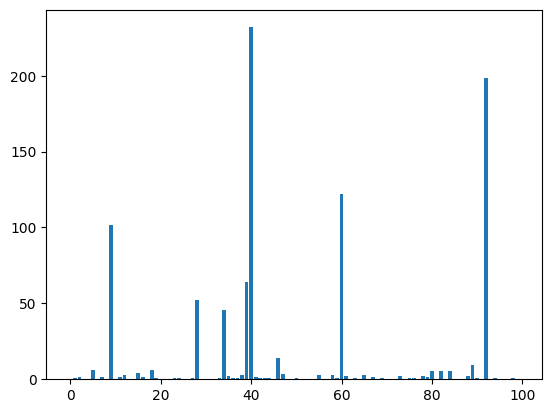

In [70]:
# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_regression, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()